# Importing packages

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard
import datetime as dt
from dateutil.relativedelta import relativedelta
from yahoo_fin.stock_info import get_data,tickers_dow as dow,tickers_nasdaq as nasdaq,tickers_sp500 as sp500,get_premarket_price,get_postmarket_price
from yahoo_fin.options import get_calls,get_puts,get_expiration_dates

# Calculating Bollinger Bands

In [2]:
# Step 1: Calculate SMA (20-period)
def get_SMA(closing_prices, days):
    return closing_prices.rolling(days).mean()
# Step 2: Calculate std. deviation (14-period)
def get_std_dev(closing_prices, days):
    return closing_prices.rolling(days).std()
# Step 3: Create Bollinger Bands (1.5 std dev)
def get_BB(closing_prices, SMA_days, std_dev_days, rate):
    sma = get_SMA(closing_prices, SMA_days)
    std_dev = get_std_dev(closing_prices, std_dev_days)
    upper_bollinger = sma + std_dev*rate
    lower_bollinger = sma - std_dev*rate
    return upper_bollinger,lower_bollinger

# Calculating Keltner Channels

In [3]:
# Step 1: Calculate EMA (20-period)
def get_EMA(closing_prices, days):
    multiplier = 2 / (days + 1)
    ema = [closing_prices[0]]
    for price,EMA_yesterday in zip(closing_prices[1:],ema):
        ema.append(price * multiplier + EMA_yesterday * (1 - multiplier))
    return ema
# Step 2: Calculate ATR (20-period)
def get_ATR(high_prices,low_prices,closing_prices,days):
    high_low = high_prices-low_prices
    high_close = np.abs(high_prices-closing_prices.shift())
    low_close = np.abs(low_prices-closing_prices.shift())
    ranges = pd.concat([high_low,high_close,low_close],axis=1)
    trueRange = np.max(ranges,axis=1)
    atr = trueRange.rolling(days).sum()/days
    return atr
# Step 3: Calculate Keltner Channel
def get_KC(ema,shift,atr):
    upper_kc = ema + shift*atr
    lower_kc = ema - shift*atr
    return upper_kc,lower_kc

# Calculate Momentum

In [4]:
def get_momentum(closing_prices,days):
    momentum = []
    for day in range(days):
        momentum.insert(day,None)
    for current_price,previous_price in zip(closing_prices[days:],closing_prices):
        momentum.append(current_price - previous_price)
    return momentum

# Gather data

In [5]:
def gather_data(data):
    if not isinstance(data,pd.core.frame.DataFrame):
        df = pd.read_csv(data)
    else:
        df = data
    closing_prices = df['close']
    high_prices = df['high']
    low_prices = df['low']
    df['SMA'] = get_SMA(closing_prices,20)
    df['EMA'] = get_EMA(closing_prices,20)
    df['ATR'] = get_ATR(high_prices,low_prices,closing_prices,14)
    df['upper_KC'],df['lower_KC'] = get_KC(df['EMA'],1.5,df['ATR'])
    df['bollinger_up'],df['bollinger_down'] = get_BB(closing_prices,20,14,1.5)
    df['MA'] = get_SMA(closing_prices,14)
    df['momentum'] = get_momentum(closing_prices,14)
    return df

# Screener Algorithm

In [6]:
def screener(company):
    calls = ''
    puts = ''
    fail = ''
    days_to_check = [-1,-2,-3,-4,-5]
    current_status = ''
    for day in days_to_check:
        today = company.iloc[day]
        ticker = today['ticker']
        today_price = today['close']
        today_upper_kc = today['upper_KC']
        today_lower_kc = today['lower_KC']
        today_upper_bb = today['bollinger_up']
        today_lower_bb = today['bollinger_down']
        today_ma = today['MA']
        today_momentum = today['momentum']
        if(today_upper_bb < today_upper_kc and today_lower_bb > today_lower_kc and today_price > today_ma and today_momentum > 0 and current_status!='put'):
            calls = ticker
            current_status = 'call'
        elif(today_upper_bb < today_upper_kc and today_lower_bb > today_lower_kc and today_price < today_ma and today_momentum < 0 and current_status!='call'):
            puts = ticker
            current_status = 'put'
        else:
            if day !=-1:
                calls = ''
                puts = ''
                fail = f'{ticker} failed {current_status} {(day)*(-1)-1} day(s) ago'
            break
    return calls,puts,fail

# Screener

In [57]:
today = dt.date.today()
last_year = (dt.datetime.now()-relativedelta(years=1))

calls = []
puts = []
fails = []

# Check an index
def check_index(function):
    index = function()
    index_hist = {}
    for ticker in index:
        data = get_data(ticker, start_date = last_year, end_date = today, index_as_date = True, interval = '1d')
        company = gather_data(data)
        company_calls,company_puts,company_fails = screener(company)
        if company_calls!='':
            calls.append(company_calls)
        if company_puts!='':
            puts.append(company_puts)
        if company_fails!='':
            fails.append(company_fails)
    return calls,puts,fails


# Check individual stock
def check_stock(ticker):
    data = get_data(ticker, start_date = last_year, end_date = today, index_as_date = True, interval = '1d')
    company = gather_data(data)
    company_calls,company_puts,company_fails = screener(company)
    if company_calls!='':
            calls.append(company_calls)
    if company_puts!='':
        puts.append(company_puts)
    if company_fails!='':
        fails.append(company_fails)
    return calls,puts,fails

# Check custom stock
def check_custom_stock(csv):
    company = gather_data(csv)
    company_calls,company_puts,company_fails = screener(company)
    if company_calls!='':
            calls.append(company_calls)
    if company_puts!='':
        puts.append(company_puts)
    if company_fails!='':
        fails.append(company_fails)
    return calls,puts,fails

In [58]:
#stock_calls,stock_puts,stock_fails = check_index(dow)
stock_calls,stock_puts,stock_fails = check_stock('AXP')
print(f'calls ({len(stock_calls)}): {stock_calls}\nputs ({len(stock_puts)}): {stock_puts}\nfails ({len(stock_fails)}): {stock_fails}')

calls (0): []
puts (0): []
fails (1): ['AXP failed call 3 day(s) ago']


# Get pre/post market prices

In [11]:
def is_premarket(current):
    start = dt.time(4,0,0)
    end = dt.time(9,30,0)
    return start<=current<=end

def is_postmarket(current):
    start = dt.time(16,0,0)
    end = dt.time(20,0,0)
    return start<=current<=end

def get_pre_post_market(ticker,current_hour):
    if is_premarket(current_hour):
        data = get_premarket_price(ticker)
    elif is_postmarket(current_hour):
        data = get_postmarket_price(ticker)
    else:
        data = 'Not pre/post market'
    #company = gather_data(data)
    print(data)

current_hour = dt.datetime.now().time()
get_pre_post_market('AAPL',current_hour)

146.76


# Plotter

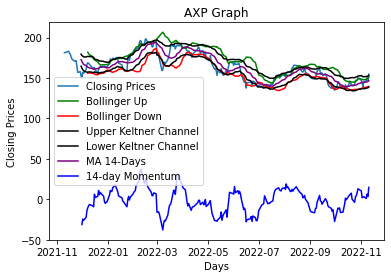

In [59]:
%matplotlib inline

today = dt.date.today()
last_year = (dt.datetime.now()-relativedelta(years=1))
ticker = 'AXP'
data = get_data(ticker=ticker, start_date = last_year, end_date = None, index_as_date = True, interval = '1d')
df = gather_data(data)
plt.title(ticker + ' Graph')
plt.xlabel('Days')
plt.ylabel('Closing Prices')
plt.plot(df['close'], label='Closing Prices')
plt.plot(df['bollinger_up'], label='Bollinger Up', c='green')
plt.plot(df['bollinger_down'], label='Bollinger Down', c='red')
plt.plot(df['upper_KC'], label='Upper Keltner Channel', c='black')
plt.plot(df['lower_KC'], label='Lower Keltner Channel', c='black')
plt.plot(df['MA'], label='MA 14-Days', c='purple')
plt.plot(df['momentum'], label='14-day Momentum', c='blue')
plt.legend()
plt.show()

# ML Predictions PART 1: Data Pre-Processing

In [55]:
# Step 1: Read data
today = dt.date.today()
last_year = (dt.datetime.now()-relativedelta(years=1))
ticker = 'AMD'
data = get_data(ticker, start_date = last_year, end_date = today, index_as_date = True, interval = '1d')
dataset_train = gather_data(data)
dataset_train.index.name = 'Date'
#company.dropna(inplace=True)
print(dataset_train.head())
# Select features to be involved in training and prediction
features = list(dataset_train[['open','high','low','volume','upper_KC','lower_KC','bollinger_up','bollinger_down','MA','momentum','close']])
# Extract dates (will be used in visualiation)
datelist_train = list(dataset_train.index)
datelist_train = [date.strftime('%Y-%m-%d') for date in datelist_train]
print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Features selected: {}'.format(features))

                  open        high         low       close    adjclose  \
Date                                                                     
2021-11-10  143.929993  146.300003  138.520004  139.869995  139.869995   
2021-11-11  142.960007  146.470001  140.839996  146.009995  146.009995   
2021-11-12  146.029999  148.589996  144.250000  147.889999  147.889999   
2021-11-15  148.000000  148.979996  142.860001  146.490005  146.490005   
2021-11-16  145.929993  153.080002  145.339996  152.449997  152.449997   

              volume ticker  SMA         EMA  ATR  upper_KC  lower_KC  \
Date                                                                    
2021-11-10  82989200    AMD  NaN  139.869995  NaN       NaN       NaN   
2021-11-11  67934800    AMD  NaN  140.454757  NaN       NaN       NaN   
2021-11-12  52162100    AMD  NaN  141.162875  NaN       NaN       NaN   
2021-11-15  52271300    AMD  NaN  141.670221  NaN       NaN       NaN   
2021-11-16  53100800    AMD  NaN  142.69686

In [56]:
# Step 2: Data Pre-processing
dataset_train = dataset_train[features].astype(str)
for i in features:
    for j in range(0,len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',','')
dataset_train = dataset_train.astype(float)
# Using multiple predictors (features)
training_set = dataset_train.values
print('Shape of training set == {}.'.format(training_set.shape))
print(training_set[:, 10:11])
# Feature Scaling
scaler = StandardScaler()
training_set_scaled = scaler.fit_transform(training_set)
scaler_predict = StandardScaler()
scaler_predict.fit_transform(training_set[:, 10:11])
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []
n_future = 21 # number of days we want to predict into the future
n_past = 90 # number of days we want to use to predict the future
for i in range(n_past, len(training_set_scaled)-n_future +1):
    X_train.append(training_set_scaled[i-n_past:i,0:dataset_train.shape[1]-1])
    y_train.append(training_set_scaled[i+n_future:i+n_future,0])
X_train,y_train = np.array(X_train),np.array(y_train)
print('X_train shape == {}'.format(X_train.shape))
print('y_train shape == {}'.format(y_train.shape))

Shape of training set == (252, 11).
[[139.86999512]
 [146.00999451]
 [147.88999939]
 [146.49000549]
 [152.44999695]
 [151.33999634]
 [155.02000427]
 [155.41000366]
 [152.52000427]
 [149.91999817]
 [157.80000305]
 [154.80999756]
 [161.91000366]
 [158.36999512]
 [149.11000061]
 [150.67999268]
 [144.00999451]
 [139.05999756]
 [144.8500061 ]
 [145.24000549]
 [138.1000061 ]
 [138.55000305]
 [133.80000305]
 [135.6000061 ]
 [146.5       ]
 [138.63999939]
 [137.75      ]
 [135.80000305]
 [144.25      ]
 [143.88000488]
 [146.13999939]
 [154.36000061]
 [153.1499939 ]
 [148.25999451]
 [145.1499939 ]
 [143.8999939 ]
 [150.24000549]
 [144.41999817]
 [136.1499939 ]
 [136.22999573]
 [132.        ]
 [132.        ]
 [137.30999756]
 [137.47000122]
 [132.74000549]
 [136.88000488]
 [131.92999268]
 [128.27000427]
 [121.88999939]
 [118.80999756]
 [116.52999878]
 [111.12999725]
 [110.70999908]
 [102.59999847]
 [105.23999786]
 [114.25      ]
 [116.77999878]
 [122.76000214]
 [120.08000183]
 [123.59999847]
 [12

# ML Predictions PART 2: Create a model. Training

In [ ]:
# Step 3: Building up the LSTM-based Neural Network


In [ ]:
# Step 4: Start training


# ML Predictions PART 3: Make future prediction

In [ ]:
# Step 5: 


In [ ]:
# Step 6: Visualize the predictions
